# A zero-inflated analysis of the 2020 Tour de France
Analysis code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import scipy.stats as stats
from scipy.special import gammaln
import pystan
matplotlib.rcParams['font.size'] = 18

In [38]:
# import data
data = pd.read_csv('../data/tour-de-france-data.csv')
data

,rank,rider,rider_number,team,time,bonus,penalty,stage,date,distance,...,winner_country,general,points,mountains,young,stage_winner,time_seconds,cumtime,gc_rank,timediff
0,1,Alexander Kristoff,135,Uae Team Emirates,3H 46M 13S,10,0,1,2020-08-29,156.0,...,NOR,135,135,185,105,135.0,13573,13573,1,0
1,2,Mads Pedersen,105,Trek - Segafredo,3H 46M 17S,6,0,1,2020-08-29,156.0,...,NOR,135,135,185,105,135.0,13577,13577,2,4
2,3,Cees Bol,203,Team Sunweb,3H 46M 19S,4,0,1,2020-08-29,156.0,...,NOR,135,135,185,105,135.0,13579,13579,3,6
3,4,Sam Bennett,43,Deceuninck - Quick - Step,3H 46M 23S,0,0,1,2020-08-29,156.0,...,NOR,135,135,185,105,135.0,13583,13583,4,10
4,5,Peter Sagan,21,Bora - Hansgrohe,3H 46M 23S,0,0,1,2020-08-29,156.0,...,NOR,135,135,185,105,135.0,13583,13583,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,142,Jasper De Buyst,153,Lotto Soudal,2H 53M 32S,0,0,21,2020-09-20,122.0,...,IRL,131,43,131,131,43.0,10412,334992,142,20587
3386,143,Marco Haller,65,Bahrain - Mclaren,2H 53M 32S,0,0,21,2020-09-20,122.0,...,IRL,131,43,131,131,43.0,10412,335192,143,20787
3387,144,Caleb Ewan,151,Lotto Soudal,2H 53M 32S,0,0,21,2020-09-20,122.0,...,IRL,131,43,131,131,43.0,10412,335430,144,21025
3388,145,Frederik Frison,156,Lotto Soudal,2H 55M 42S,0,0,21,2020-09-20,122.0,...,IRL,131,43,131,131,43.0,10542,336113,145,21708


In [39]:
# define contenders
contenders = [131, 11, 101, 61, 94, 141, 1, 3, 14, 29, 71, 91, 121, 161]
data['contender'] = data['rider']
for n in range(data.shape[0]):
    if data['rider_number'][n] not in contenders:
        data['contender'][n] = 'Other'
    # end if
# end for

<ipython-input-39-32261690d09f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['contender'][n] = 'Other'


In [73]:
# create training data
tmp_data = data
tmp_data = sm.add_constant(
    pd.concat((
    tmp_data[['stage', 'distance']],
        pd.concat((pd.get_dummies(tmp_data.team),
                   pd.get_dummies(tmp_data.contender)
                   ), axis = 1)
        ), axis = 1))
tmp_data
training_data = tmp_data[tmp_data.stage < 20]
training_data

,const,stage,distance,Ag2r La Mondiale,Astana Pro Team,B&B Hotels - Vital Concept P / B Ktm,Bahrain - Mclaren,Bora - Hansgrohe,Ccc Team,Cofidis,...,Guillaume Martin,Miguel Angel Lopez,Mikel Landa,Other,Primož Roglic,Richard Carapaz,Richie Porte,Rigoberto Uran,Tadej Pogacar,Tom Dumoulin
0,1.0,1,156.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1.0,1,156.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1.0,1,156.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1.0,1,156.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1.0,1,156.0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3222,1.0,19,166.5,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3226,1.0,19,166.5,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3230,1.0,19,166.5,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3237,1.0,19,166.5,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [75]:
# fit tweedie
mod = sm.GLM(endog = data[data.stage<20].timediff, exog = training_data, family = sm.families.Tweedie(var_power = 1.5))
res = mod.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               timediff   No. Observations:                 3098
Model:                            GLM   Df Residuals:                     3061
Model Family:                 Tweedie   Df Model:                           36
Link Function:                    log   Scale:                          17.953
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 02 Dec 2020   Deviance:                       80936.
Time:                        18:18:25   Pearson chi2:                 5.50e+04
No. Iterations:                    18                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [77]:
# generate test data
test_data = tmp_data[tmp_data.stage == 20]
test_data

,const,stage,distance,Ag2r La Mondiale,Astana Pro Team,B&B Hotels - Vital Concept P / B Ktm,Bahrain - Mclaren,Bora - Hansgrohe,Ccc Team,Cofidis,...,Guillaume Martin,Miguel Angel Lopez,Mikel Landa,Other,Primož Roglic,Richard Carapaz,Richie Porte,Rigoberto Uran,Tadej Pogacar,Tom Dumoulin
2931,1.0,20,36.2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2933,1.0,20,36.2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2936,1.0,20,36.2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2937,1.0,20,36.2,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2938,1.0,20,36.2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3288,1.0,20,36.2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3292,1.0,20,36.2,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3295,1.0,20,36.2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3299,1.0,20,36.2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [78]:
# predict stage 20
preds = res.predict(test_data)
predictions = data[data.stage == 20]
predictions = predictions[['rider', 'timediff']]
predictions['predictions'] = preds
predictions

,rider,timediff,predictions
2931,Tadej Pogacar,0,175.958534
2933,Primož Roglic,59,28.442299
2936,Richie Porte,210,389.943462
2937,Mikel Landa,358,384.682616
2938,Enric Mas,367,447.779604
...,...,...,...
3288,Jasper De Buyst,20587,37119.938073
3292,Marco Haller,20787,23052.411951
3295,Caleb Ewan,21025,37119.938073
3299,Frederik Frison,21578,37119.938073


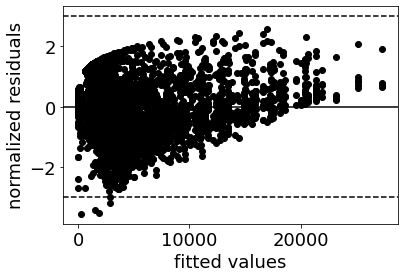

In [99]:
# normalized residuals
phi = 17.953
fitted = res.fittedvalues
response = data[data.stage<20].timediff
norm_residuals = (fitted - response) / np.sqrt(phi * fitted**1.5)

# plot
plt.plot(fitted, norm_residuals, 'ok')
plt.axhline(y = 0, c = 'k')
plt.axhline(y = -3, c = 'k', ls = '--')
plt.axhline(y = 3, c = 'k', ls = '--')
plt.xlabel('fitted values')
plt.ylabel('normalized residuals')
plt.savefig('../doc/fig/norm_residuals.jpg')

In [ ]:
# code stan model
stan_code = """
data {
  int<lower=0> n; // number of observations
  int<lower=0> k_team; // number of team dummy variables
  real y[n]; // responses
  int stage[n];
  real distance[n];
  matrix[n,k_team] team; // team dummy variables
  matrix[n,k_contender] contender; // contender dummy variables  
}
parameters {
  real beta0;
  real beta1;
  real beta2;
  vector[k_team] beta3;
  vector[k_contender] beta4;
  real<lower=0> gamma0;
  real<lower=0> gamma1;
  int N[n];
}
transformed parameters {
  real mu[n];
  real<lower=0> phi[n];
  for (i in 1:n){
      
      mu[i] = beta0 + beta1*stage[i] + beta2*distance[i] + beta3*team[i] + beta4*contender[i];
      phi[i] = (gamma0 + gamma1*stage[i])^2;
  }
}
model {
  beta0 ~ normal(0, 1e5);
  beta1 ~ normal(0, 1e5);
  beta2 ~ normal(0, 1e5);
  beta3 ~ normal(0, 1e5);
  beta4 ~ normal(0, 1e5);
  beta5 ~ normal(0, 1e5);
  gamma0 ~ normal(0, 1e5);
  gamma1 ~ normal(0, 1e5);
  N ~ poisson(lambda)
  
  for(i in 1:n){
      if(y[i] == 0){
      y[i] = 0;
      }else{
      y[i] ~ gamma(N[i], )
      }
  }
  
  y ~ normal(mu, sig);
}
"""